**This code developed a one-step DenseNet Model that was built to classify CXR images to predict the need of COVID-19 ICU stay.**



Reference:
Pytorch tutorials: Finetuning Torchvision Models: Nathan Inkawhich https://github.com/inkawhich__


In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


Inputs
------




In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/content/drive/MyDrive/11522 Capstone Research Project/Dataset/icu"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 3

# Number of epochs to train for 
num_epochs = 500

# learning rate
lr=0.0002


# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

Helper Functions
----------------

Model Training and Validation Code



In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 40.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                         
                        outputs, aux_outputs = model(inputs)
                        aux1, aux2, outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)

                       

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {} Best val Acc: {:4f} Best val Loss: {:4f}'.format(best_epoch,best_acc,best_loss))
    #print('Best Model Weights: ',best_model_wts)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history, val_loss_history,train_loss_history

Set Model Parameters’ .requires_grad attribute




In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------
Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)





In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

Load Data
---------




In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3d64190610>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f3d66604690>}

Create the Optimizer
--------------------

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Model Trained from Scratch
------------------------------------------


In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=lr, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
model_ft,scratch_acc_hist,train_acc_hist,val_loss_hist,train_loss_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/499
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6878 Acc: 0.5616
valid Loss: 0.7513 Acc: 0.6316

Epoch 1/499
----------
train Loss: 0.6652 Acc: 0.6027
valid Loss: 0.7689 Acc: 0.6316

Epoch 2/499
----------
train Loss: 0.6454 Acc: 0.6438
valid Loss: 0.6755 Acc: 0.5789

Epoch 3/499
----------
train Loss: 0.6296 Acc: 0.6575
valid Loss: 0.7023 Acc: 0.5789

Epoch 4/499
----------
train Loss: 0.6720 Acc: 0.5753
valid Loss: 0.7721 Acc: 0.6316

Epoch 5/499
----------
train Loss: 0.6394 Acc: 0.6849
valid Loss: 0.6355 Acc: 0.6842

Epoch 6/499
----------
train Loss: 0.6269 Acc: 0.6575
valid Loss: 0.6731 Acc: 0.6316

Epoch 7/499
----------
train Loss: 0.6149 Acc: 0.6438
valid Loss: 0.6785 Acc: 0.5789

Epoch 8/499
----------
train Loss: 0.6145 Acc: 0.6301
valid Loss: 0.6165 Acc: 0.6316

Epoch 9/499
----------
train Loss: 0.6387 Acc: 0.6575
valid Loss: 0.6097 Acc: 0.6842

Epoch 10/499
----------
train Loss: 0.6466 Acc: 0.6301
valid Loss: 0.5859 Acc: 0.6842

Epoch 11/499
----------
train Loss: 0.6161 Acc: 0.7123
valid Loss: 0.5688 Ac

In [ ]:
# Saving and Loading Models with Shapes
torch.save(model_ft, 'ICU_model.pth')

# load the model 
# model = torch.load('model.pth')

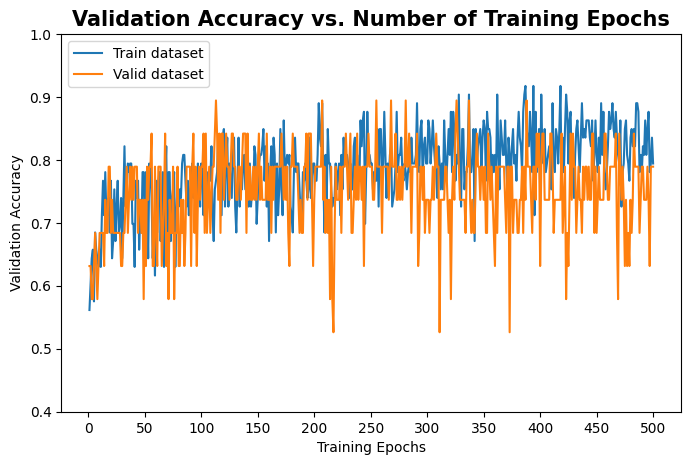

In [ ]:
# Plot the training and validation accuracy vs. number 
#  of training epochs for the model trained from scratch


ohist_acc = []
shist_acc = []

ohist_acc = [h.cpu().numpy() for h in train_acc_hist]
shist_acc = [h.cpu().numpy() for h in scratch_acc_hist]

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.title("Validation Accuracy vs. Number of Training Epochs",fontsize=15,fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist_acc,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist_acc,label="Valid dataset")
plt.ylim((0.4,1.))
plt.xticks(np.arange(0, num_epochs+1, 50.0))

plt.legend()
plt.show()

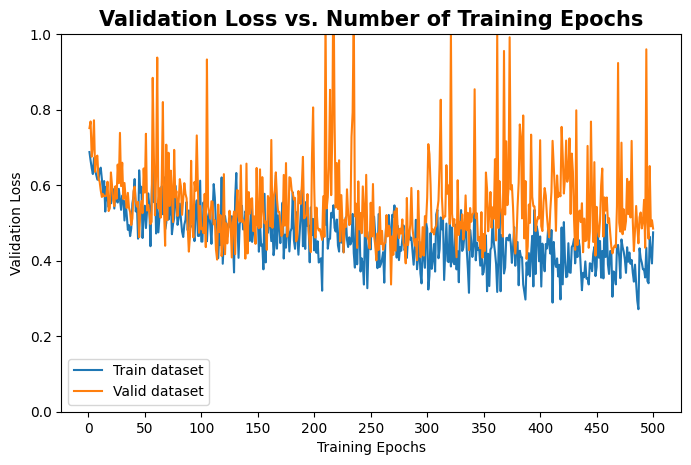

In [ ]:
# Plot the training and validation loss vs. number 
#  of training epochs for the model trained from scratch


ohist_loss = []
shist_loss = []

ohist_loss = [h for h in train_loss_hist]
shist_loss = [h for h in val_loss_hist]

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.title("Validation Loss vs. Number of Training Epochs",fontsize=15,fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),ohist_loss,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist_loss,label="Valid dataset")
plt.ylim((0,1))
plt.xticks(np.arange(0, num_epochs+1, 50.0))
plt.legend()
plt.show()

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[11.,  0.],
        [ 2.,  6.]])


In [ ]:
Accuracy = (confusion_matrix[0,0]+confusion_matrix[1,1])/confusion_matrix.sum()
Misclassification_rate = (confusion_matrix[0,1]+confusion_matrix[1,0])/confusion_matrix.sum()


[TNR, TPR] = confusion_matrix.diag()/confusion_matrix.sum(1)

Precision = confusion_matrix[1,1] / confusion_matrix.sum(0)[1]

print('Accuracy: ',Accuracy)
print('Misclassification Rate: ',Misclassification_rate)
print('TPR: ', TPR)
print('TNR: ', TNR)

print('Precision: ', Precision)


Accuracy:  tensor(0.8947)
Misclassification Rate:  tensor(0.1053)
TPR:  tensor(0.7500)
TNR:  tensor(1.)
Precision:  tensor(1.)


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
def predict_model(model, dataloaders, plot=True):
  predictions = []
  img_label = []
  

  with torch.no_grad():
    for inputs, labels in dataloaders:
      labels = labels.int()
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      
      #outputs = outputs.cpu().detach().numpy()
      preds = preds.cpu().detach().numpy()
      labels = labels.cpu().detach().numpy()
      


      predictions.append(preds)
      img_label.append(labels)
      return predictions, img_label

In [ ]:
# model prediction 
testloader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=19,shuffle=True, num_workers=2)
classification, img_label = predict_model(model_ft, testloader)
print(classification)
print(img_label)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1])]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)]


In [ ]:
# load images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print labels
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


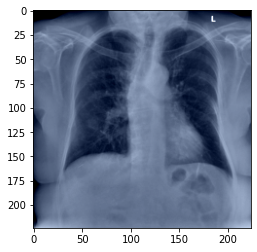

image label:  0
classification: 0


In [ ]:
# correctly -- True Negative
id = 3
imshow(images[id])
print('image label: ',img_label[0][id])
print('classification:',classification[0][id])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


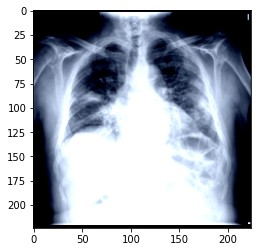

image label:  1
classification: 1


In [ ]:
# correctly -- True Positive
id = 16
imshow(images[id])
print('image label: ',img_label[0][id])
print('classification:',classification[0][id])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


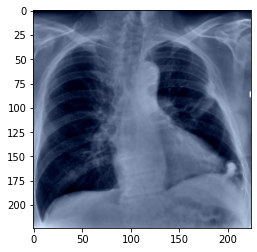

image label:  1
classification: 0


In [ ]:
# incorrectly classified -- False Negative
id = 14
imshow(images[id])
print('image label: ',img_label[0][id])
print('classification:',classification[0][id])

In [ ]:
# incorrectly classified -- False Postive 
# no image is classified as this catergory